# Homework II

Gonçalo Bárias (ist1103124) & Raquel Braunschweig (ist1102624)

This Notebook only contains our solution for the programming and critical analysis section of the Homework (Part II). Our solution for the pen and paper section (Part I) can be found on the pdf report. Even though the question I-1b has code for multivariate distribution calculus, we decided to only include it on the pdf report.

## II. Programming and critical analysis [7v]

**Considering the `column_diagnosis.arff` dataset available at the course webpage’s homework tab. Using `sklearn`, apply a 10-fold stratified cross-validation with shuffling (`random_state=0`) for the
assessment of predictive models along this section.**

### 1) [3v]

**Compare the performance of kNN with k = 5 and Naïve Bayes with Gaussian assumption
(consider all remaining parameters for each classifier as `sklearn`'s default):**

- **(a) Plot two boxplots with the fold accuracies for each classifier.**

In [1]:
import matplotlib.pyplot as plt, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.io.arff import loadarff

In [2]:
# Read the ARFF file and prepare data
data = loadarff("./data/column_diagnosis.arff")
df = pd.DataFrame(data[0])
df["class"] = df["class"].str.decode("utf-8")
X, y = df.drop("class", axis=1), df["class"]

In [3]:
# Define cross-validation strategy
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Initialize classifiers
knn_predictor = KNeighborsClassifier(n_neighbors=5)
nb_predictor = GaussianNB()

# Evaluate classifiers
knn_accs = cross_val_score(knn_predictor, X, y, cv=folds, scoring="accuracy")
nb_accs = cross_val_score(nb_predictor, X, y, cv=folds, scoring="accuracy")

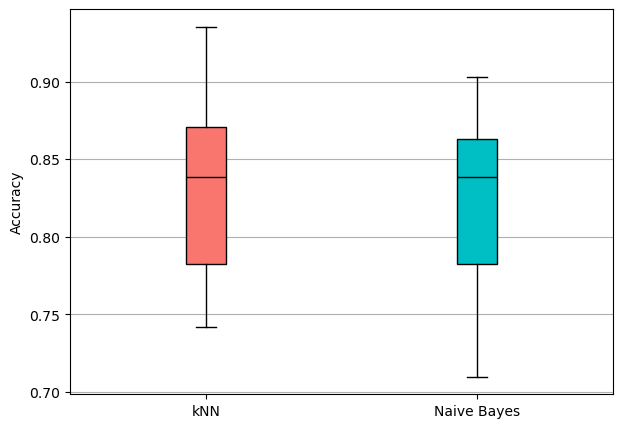

In [4]:
# Plot boxplots
plt.figure(figsize=(7, 5))
b_plot = plt.boxplot(
    [knn_accs, nb_accs], patch_artist=True, labels=["kNN", "Naive Bayes"]
)

colors = ["#f8766d", "#00bfc4"]
for patch, color in zip(b_plot["boxes"], colors):
    patch.set_facecolor(color)
for median in b_plot["medians"]:
    median.set_color("black")

plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.show()

- **(b) Using `scipy`, test the hypothesis "kNN is statistically superior to Naïve Bayes regarding accuracy", asserting whether is true.**

In [5]:
from scipy.stats import ttest_rel

# Is kNN better than Naive Bayes?
res = ttest_rel(knn_accs, nb_accs, alternative="greater")
print("Is kNN > Naive Bayes? pval =", res.pvalue)

Is kNN > Naive Bayes? pval = 0.19042809062064092


### 2) [2.5v]

**Consider two kNN predictors with k = 1 and k = 5 (uniform weights, Euclidean distance,
all remaining parameters as default). Plot the differences between the two cumulative confusion
matrices of the predictors. Comment.**

In [6]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.io.arff import loadarff

In [7]:
# Read the ARFF file and prepare data
data = loadarff("./data/column_diagnosis.arff")
df = pd.DataFrame(data[0])
df["class"] = df["class"].str.decode("utf-8")
X, y = df.drop("class", axis=1), df["class"]

In [8]:
# Initialize StratifiedKFold with 10 folds and shuffling
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Create kNN classifiers with k=1 and k=5
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_5 = KNeighborsClassifier(n_neighbors=5)

labels = ["Hernia", "Normal", "Spondylolisthesis"]
cm_1, cm_5 = np.zeros((3, 3)), np.zeros((3, 3))
for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    # Fit kNN classifiers and assess
    knn_1.fit(X_train, y_train)
    knn_5.fit(X_train, y_train)
    knn_1_pred, knn_5_pred = knn_1.predict(X_test), knn_5.predict(X_test)
    cm_1 += np.array(confusion_matrix(y_test, knn_1_pred, labels=labels))
    cm_5 += np.array(confusion_matrix(y_test, knn_5_pred, labels=labels))

# Calculate cumulative confusion matrices
cm_diff = cm_1 - cm_5
cm_diff_df = pd.DataFrame(cm_diff, index=labels, columns=labels)

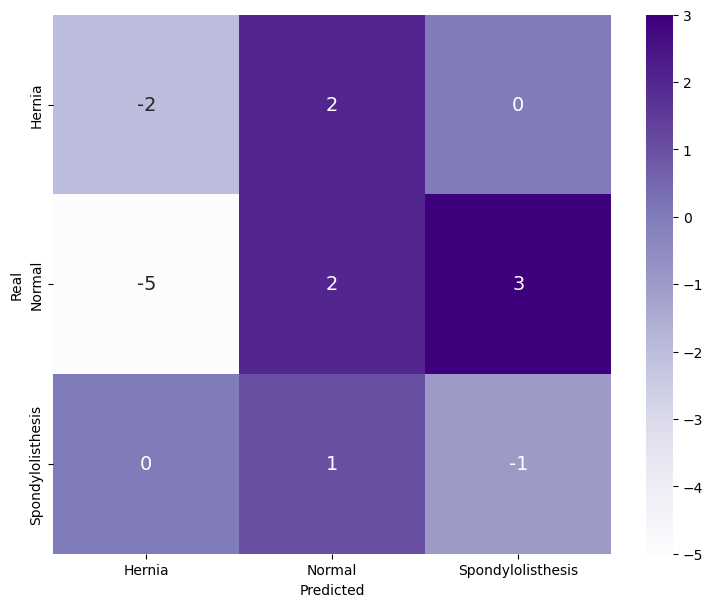

In [9]:
# Plot the differences
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_diff_df, cmap="Purples", annot=True, annot_kws={"fontsize": 14}, fmt="g"
)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

Upon examination of the difference matrix derived from the cumulative confusion matrices, it is evident
that the kNN model with k=5 surpasses the performance of k=1.

For each cell in this matrix, we can determine which model (k=1 or k=5) had the most observations
by noting if the cell value is negative or positive. A positive value indicates that k=1 had the most
observations, while a negative value indicates that k=5 was the one with more observations.

This superiority of the k=5 model is shown by the negative sum of the main diagonal elements, signifying
higher accuracy. Additionally, the fact that the sum of incorrect predictions (false positives and false
negatives) is positive suggests that k=5 has fewer miss classifications.

**Therefore**, utilizing k=5 appears to be the preferable choice over k=1 for this task.

### 3) [1.5v]

**Considering the unique properties of `column_diagnosis`, identify three possible difficulties
of Naïve Bayes when learning from the given dataset.**

Here are three possible difficulties of Naïve Bayes when learning from the given dataset, in no particular order:
- To apply Naïve Bayes, we assume that all variables were independent of one another, which might not be case, thus explaining a potential problem that would hinder its accuracy. In medical datasets, like this one, it is common for attributes to have complex dependencies, which Naïve Bayes cannot account for.
- There may be an inadequacy of Gaussian assumption, because the data used (column_diagnosis.arff) is not very big (around 300 observations, with only some being used for training), and so there might not be enough data for probability density function/probability mass function approximations.
- Probabilities are estimated based on the number of occurences on the given training data, and so there might be imbalanced number of occurences for some given class. This might affect the value of the prior, creating biases in a Maximum a Priori assumption.